In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import sys
import os
from torch.utils.data import DataLoader
import yaml

/u/kazumak2/.conda/envs/pytorch-env/lib/python3.9/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [2]:
# compactly add project src and analysis/zero-shot to sys.path if not already present
for rel in ('src', 'analysis/forecasting'):
    p = os.path.abspath(os.path.join(os.getcwd(), rel))
    if p not in sys.path:
        sys.path.append(p)

# now imports that rely on those paths
from utils import SequentialDeepONetDataset
from helper import convert2dim, compute_metrics_region, plot_field_region, fit, load_model_experiment

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [3]:
input_data = np.load('data/neutron_data_22yrs.npy')
trunk = np.load('data/grid_points.npy')
target = np.load('data/dose_array.npy')

print("Input data shape:", input_data.shape)
print("Trunk shape:", trunk.shape)
print("Target shape:", target.shape)

Input data shape: (8400, 12)
Trunk shape: (65341, 2)
Target shape: (8400, 65341)


In [4]:
trunk[:, 0] = (trunk[:, 0] - np.min(trunk[:, 0])) / (np.max(trunk[:, 0]) - np.min(trunk[:, 0]))
trunk[:, 1] = (trunk[:, 1] - np.min(trunk[:, 1])) / (np.max(trunk[:, 1]) - np.min(trunk[:, 1]))

In [5]:
from forecasting_analysis import create_windows_forecasting_with_index

dates = pd.date_range("2001-01-01", "2023-12-31", freq="D")

W, H = 30, 0
X_all, y_all, tgt_idx = create_windows_forecasting_with_index(input_data, target, W, H)
tgt_dates = dates[tgt_idx]

train_mask = (tgt_dates <= pd.Timestamp("2021-12-31"))
val_mask   = (tgt_dates >= pd.Timestamp("2022-01-01")) & (tgt_dates <= pd.Timestamp("2022-12-31"))
test_mask  = (tgt_dates >= pd.Timestamp("2023-01-01")) & (tgt_dates <= pd.Timestamp("2023-12-31"))

X_train, y_train = X_all[train_mask], y_all[train_mask]
X_val,   y_val   = X_all[val_mask],   y_all[val_mask]
X_test,  y_test  = X_all[test_mask],  y_all[test_mask]

# check shapes
print("Train set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)

Train set: torch.Size([7641, 30, 12]) torch.Size([7641, 65341])
Validation set: torch.Size([365, 30, 12]) torch.Size([365, 65341])
Test set: torch.Size([365, 30, 12]) torch.Size([365, 65341])


In [6]:
scaler_input = MinMaxScaler()
X_train_scaled = scaler_input.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_val_scaled   = scaler_input.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
X_test_scaled  = scaler_input.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Fit on ALL training pixels (flattened)
scaler_target = MinMaxScaler()

# Transform sets
y_train_scaled = scaler_target.fit_transform(y_train)[..., np.newaxis]
y_val_scaled   = scaler_target.transform(y_val)[..., np.newaxis]
y_test_scaled  = scaler_target.transform(y_test)[..., np.newaxis]

# create datasets
train_dataset = SequentialDeepONetDataset(X_train_scaled, trunk, y_train_scaled)
val_dataset   = SequentialDeepONetDataset(X_val_scaled,   trunk, y_val_scaled)
test_dataset  = SequentialDeepONetDataset(X_test_scaled,  trunk, y_test_scaled)

# create dataloaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [7]:
model = load_model_experiment('analysis/baseline/single_branch/lstm_window_30.pth')
model = model.to(device)

Loaded model from analysis/baseline/single_branch/lstm_window_30.pth


In [8]:
preds, targets = fit(model, test_loader, device, scaler_target)

In [9]:
# ---- load YAML (list of dicts) ----
with open("analysis/forecasting/yaml/city_columns.yaml", "r", encoding="utf-8") as f:
    cities = yaml.safe_load(f)

# ---- unpack fields ----
names = [c["name"] for c in cities]
cols  = np.array([int(c["col"])   for c in cities], dtype=np.int64)
lat_i = np.array([int(c["lat_i"]) for c in cities], dtype=np.int16)
lon_i = np.array([int(c["lon_i"]) for c in cities], dtype=np.int16)

print("Names:", names)
print("Cols:", cols.shape, "Lat/Lon:", lat_i.shape, lon_i.shape)

Names: ['New_York', 'San_Francisco', 'São_Paulo', 'London', 'Helsinki', 'Cairo', 'Johannesburg', 'Riyadh', 'Delhi', 'Tokyo', 'Jakarta', 'Sydney']
Cols: (12,) Lat/Lon: (12,) (12,)


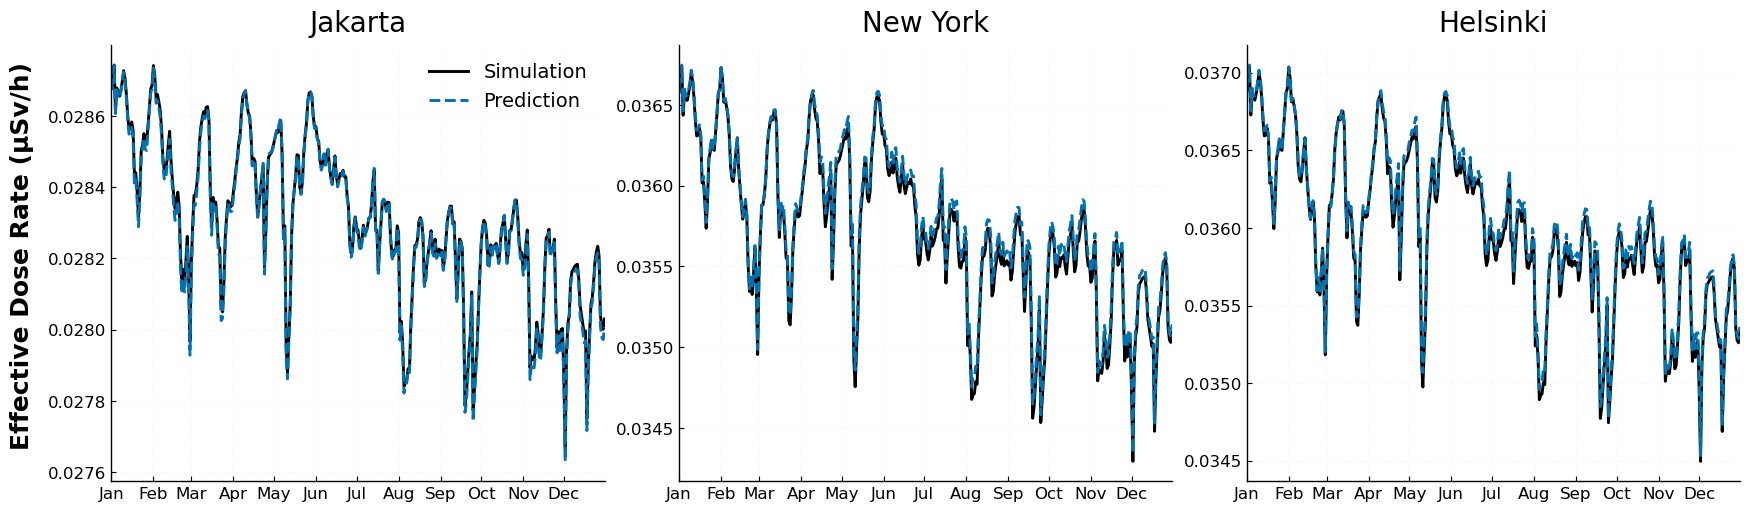

In [10]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import numpy as np
from scipy.stats import spearmanr

# ============================================================
# REPRESENTATIVE CITIES
# ============================================================

REPRESENTATIVE = ["Jakarta", "New_York", "Helsinki"]
city_to_idx    = {c["name"]: idx for idx, c in enumerate(cities)}
rep_indices    = [city_to_idx[name] for name in REPRESENTATIVE]

# ============================================================
# FIGURE CONFIGURATION (Nature-tier)
# ============================================================

plt.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 12,
    "axes.labelsize": 15,
    "axes.titlesize": 20,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 14,
    "axes.linewidth": 1.0,
})

LINE_W_SIM  = 2.1
LINE_W_PRED = 2.1

SIM_COLOR  = "#000000"
PRED_COLOR = "#0072B2"

fig, ax = plt.subplots(
    1, 3, figsize=(17, 5.0),
    constrained_layout=True
)

month_locator = mdates.MonthLocator(bymonthday=1)
month_fmt     = mdates.DateFormatter('%b')   # Jan, Feb, ...

# ============================================================
# PLOT EACH REPRESENTATIVE CITY
# ============================================================

for k, idx_city in enumerate(rep_indices):

    city = cities[idx_city]
    c_name = city["name"]
    col = int(city["col"])

    targ = targets[:, col]
    pred = preds[:, col]
    dates = tgt_dates[test_mask]

    # Compute Spearman correlation
    rho, _ = spearmanr(pred, targ)

    axi = ax[k]

    # Simulation curve
    axi.plot(
        dates, targ,
        color=SIM_COLOR,
        linestyle="-",
        linewidth=LINE_W_SIM,
        label="Simulation"
    )

    # Prediction curve
    axi.plot(
        dates, pred,
        color=PRED_COLOR,
        linestyle="--",
        linewidth=LINE_W_PRED,
        label="Prediction"
    )

    # Panel title
    axi.set_title(c_name.replace("_", " "), fontsize=20, pad=10)

    # X-axis formatting
    axi.set_xlim(dates[0], dates[-1])
    axi.xaxis.set_major_locator(month_locator)
    axi.xaxis.set_major_formatter(month_fmt)

    # Grid styling
    axi.grid(alpha=0.15, linestyle=":", linewidth=0.6)

    # Remove spines
    axi.spines['top'].set_visible(False)
    axi.spines['right'].set_visible(False)
    axi.tick_params(axis="both", direction='in')

    # ===============================
    #  Add correlation annotation
    # ===============================
    #axi.text(
    #    0.02, 0.92,
    #    r"$\rho$ = {:.3f}".format(rho),
    #    transform=axi.transAxes,
    #    fontsize=15,
    #    fontweight='bold',
    #    ha='left', va='top'
    #)

# ============================================================
# GLOBAL Y-LABEL + LEGEND
# ============================================================

fig.text(
    -0.02, 0.5,
    "Effective Dose Rate (µSv/h)",
    rotation="vertical",
    va="center",
    fontsize=18,
    fontweight='bold'
)

ax[0].legend(loc="upper right", frameon=False)

#plt.savefig(
#    "analysis/baseline/figures/loc_prediction_results_Nature_final.pdf",
#    bbox_inches="tight", dpi=400
#)

plt.show()


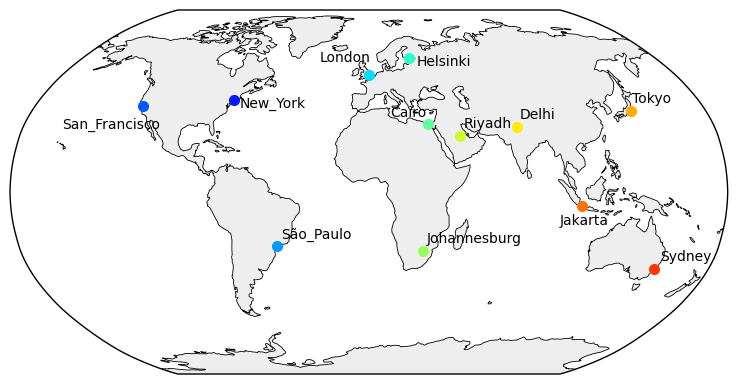

In [11]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np

# ============================================================
# If lat_i, lon_i in YAML are TRUE geographic coordinates:
#    - simply convert them to float
# ============================================================

lats = np.array(lat_i, dtype=float)
lons = np.array(lon_i, dtype=float)

# If instead lat_i/lon_i are GRID indices and you want to convert:
# Example (modify according to your dataset)
# lats = lat_vals[lat_i]
# lons = lon_vals[lon_i]

# ============================================================
# FIGURE
# ============================================================

fig = plt.figure(figsize=(10, 4))
ax = plt.axes(projection=ccrs.Robinson())

ax.set_global()
ax.coastlines(linewidth=0.6)
#ax.add_feature(cfeature.BORDERS, linewidth=0.4, alpha=0.5)
ax.add_feature(cfeature.LAND, facecolor="#eeeeee")
#ax.add_feature(cfeature.OCEAN, facecolor="#d9e6f2")

# ============================================================
# PLOT CITIES
# ============================================================

# good contrasting color palette
colors = plt.cm.jet(np.linspace(0.15, 0.85, len(names)))

for i, name in enumerate(names):
    lat = lats[i]
    lon = lons[i]

    ax.plot(
        lon, lat,
        marker="o",
        markersize=7,
        color=colors[i],
        transform=ccrs.PlateCarree()
    )

    # Label with small offset
    if name == "San_Francisco":
        ax.text(
            lon - 40, lat - 5,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='top'
        )
    elif name == "New_York":
        ax.text(
            lon + 5, lat -5,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    elif name == "London":
        ax.text(
            lon -30, lat + 5,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    elif name == "Helsinki":
        ax.text(
            lon + 4, lat - 5,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    elif name == "Cairo":
        ax.text(
            lon - 20, lat + 2,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    elif name == "Jakarta":
        ax.text(
            lon - 10, lat - 10,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )
    else:
        ax.text(
            lon + 2, lat + 2,
            name,
            fontsize=10,
            transform=ccrs.PlateCarree(),
            ha='left', va='bottom'
        )

#plt.title("City Locations Used for Forecasting Dataset", fontsize=12)
plt.tight_layout()
plt.savefig("analysis/baseline/figures/loc_city_locations.png", bbox_inches="tight", dpi=300)
plt.show()


In [12]:
pred_city = preds[:, cols, :]
targets_city = targets[:, cols, :]

# pred_city.shape -> (365, 12, 1)
# compute relative error per city
rel_errors = (pred_city.squeeze(-1) - targets_city.squeeze(-1)) / np.maximum(targets_city.squeeze(-1), 1e-6) * 100
dates = tgt_dates[test_mask]

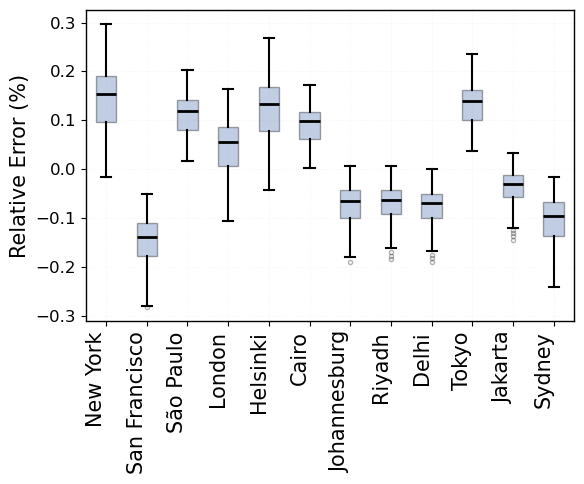

In [13]:
fig, ax = plt.subplots(figsize=(6, 5))

# rel_errors: shape = (365 days, 12 cities)
# we need one box PER CITY → input: (cities, samples)
data = [rel_errors[:, i] for i in range(rel_errors.shape[1])]

ax.boxplot(data,
           patch_artist=True,
           medianprops=dict(color="black", linewidth=2),
           boxprops=dict(facecolor="#4C72B0", alpha=0.35),
           whiskerprops=dict(color="black", linewidth=1.5),
           capprops=dict(color="black", linewidth=1.5),
           flierprops=dict(marker='o', markersize=3, alpha=0.3))

ax.set_xticks(np.arange(1, len(names)+1))
ax.set_xticklabels([n.replace("_"," ") for n in names],
                   rotation=90, ha='right', fontsize=15)

ax.set_ylabel("Relative Error (%)", fontsize=15)
#ax.set_title("City-wise Relative Error Distribution (2023)", fontsize=18)

ax.grid(alpha=0.15, linestyle=":", linewidth=0.6)
plt.tight_layout()
plt.savefig("analysis/baseline/figures/loc_error_boxplot_correct.png",dpi=300, bbox_inches="tight")
plt.show()


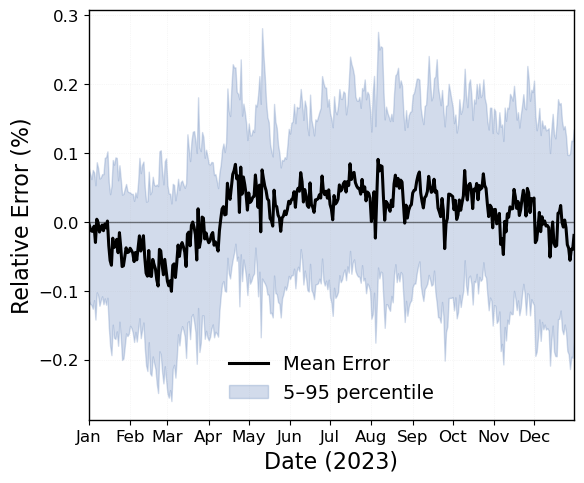

In [14]:
mean_err = rel_errors.mean(axis=1)
p05 = np.percentile(rel_errors, 5, axis=1)
p95 = np.percentile(rel_errors, 95, axis=1)

fig, ax = plt.subplots(figsize=(6, 5))

ax.plot(dates, mean_err, color="black", linewidth=2.2, label="Mean Error")
ax.fill_between(dates, p05, p95, color="#4C72B0", alpha=0.25,
                label="5–95 percentile")

ax.set_xlim(dates[0], dates[-1])
ax.xaxis.set_major_locator(month_locator)
ax.xaxis.set_major_formatter(month_fmt)
ax.axhline(0, color="black", linewidth=1, alpha=0.5)

ax.set_ylabel("Relative Error (%)", fontsize=16)
ax.set_xlabel("Date (2023)", fontsize=16)
#ax.set_title("Temporal Stability of Relative Error Across All Cities", fontsize=18)

ax.grid(alpha=0.2, linestyle=":", linewidth=0.5)
ax.legend(frameon=False, fontsize=14)

plt.tight_layout()
plt.savefig("analysis/baseline/figures/loc_error_temporal_mean.png", dpi=300)
plt.show()


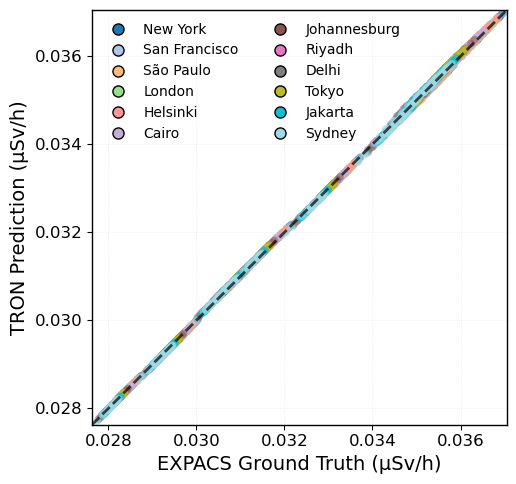

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# ------------------------------------------
# PREPARE DATA
# ------------------------------------------

# preds[:, cols, :] and targets[:, cols, :] shapes: (365, 12, 1)
y_true = targets_city.squeeze(-1)   # shape (365, 12)
y_pred = pred_city.squeeze(-1)

# Flatten across days and cities
flat_true = y_true.flatten()
flat_pred = y_pred.flatten()

# Color: one color per city
city_colors = plt.cm.tab20(np.linspace(0, 1, len(names)))

point_colors = np.repeat(city_colors, repeats=y_true.shape[0], axis=0)

# ------------------------------------------
# PLOT
# ------------------------------------------

fig, ax = plt.subplots(figsize=(6, 5))

ax.scatter(flat_true, flat_pred, s=30,
           color=point_colors, alpha=0.55, edgecolors='none')

# 1:1 Line
min_val = min(flat_true.min(), flat_pred.min())
max_val = max(flat_true.max(), flat_pred.max())
ax.plot([min_val, max_val], [min_val, max_val],color="black", linewidth=2, alpha=0.7, linestyle="--")

# Labels and style
ax.set_xlabel("EXPACS Ground Truth (µSv/h)", fontsize=14)
ax.set_ylabel("TRON Prediction (µSv/h)", fontsize=14)
#ax.set_title("Predicted vs Ground-Truth Effective Dose (All Cities, 2023)", fontsize=16)

ax.grid(alpha=0.25, linestyle=":", linewidth=0.6)
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_aspect("equal", adjustable="box")

# Optional: City legend
handles = [plt.Line2D([0], [0], marker='o', color='none',
                      markerfacecolor=city_colors[i], markersize=8,
                      label=names[i].replace("_"," "))
           for i in range(len(names))]
ax.legend(handles=handles, frameon=False, fontsize=10,
          loc="upper left", ncol=2)

plt.tight_layout()
plt.savefig("analysis/baseline/figures/loc_scatter_citycolor.png", dpi=300)
plt.show()


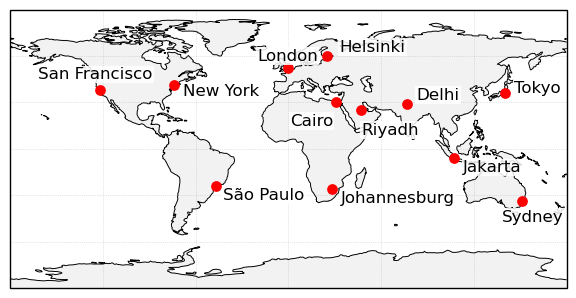

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# -------------------------------------------------
# Assume you already have this from YAML
# cities = yaml.safe_load(...)
# -------------------------------------------------
names = [c["name"] for c in cities]
lat_i = np.array([c["lat_i"] for c in cities])
lon_i = np.array([c["lon_i"] for c in cities])

plt.rcParams.update({
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.size": 12,
    "axes.titlesize": 18,
})

fig = plt.figure(figsize=(6, 5))
ax = plt.axes(projection=ccrs.PlateCarree())

# Land / coastlines
ax.add_feature(cfeature.LAND, facecolor="#f2f2f2")
ax.add_feature(cfeature.COASTLINE, linewidth=0.7)
ax.set_global()

ax.gridlines(draw_labels=False, linewidth=0.5,
             linestyle=":", color="gray", alpha=0.4)

# CITY MARKERS
ax.scatter(
    lon_i, lat_i,
    color="red", s=45, zorder=3,
    transform=ccrs.PlateCarree()
)

# ---- UPDATED OFFSETS (lon, lat degrees) ----
offsets = {
    # Americas
    "San_Francisco": (-40,  10),   # push into Pacific
    "New_York":      (  6, -4),   # move east-south away from SF text
    "São_Paulo":     (  5, -6),

    # Europe
    "London":        (-20,  8),   # move NW
    "Helsinki":      (  8,  6),   # move NE

    # Africa
    "Cairo":         (-30, -12),   # move SW
    "Johannesburg":  (  6, -6),

    # Middle East / Asia
    "Riyadh":        (  0,  -13),   # move east
    "Delhi":         (  6,  6),   # move NE
    "Tokyo":         (  6,  3),
    "Jakarta":       (  6, -6),
    "Sydney":        (  -13, -10),
}

for i, name in enumerate(names):
    pretty = name.replace("_", " ")
    dx, dy = offsets.get(name, (3, 2))
    ax.text(
        lon_i[i] + dx,
        lat_i[i] + dy,
        pretty,
        fontsize=12,
        ha="left",
        va="center",
        transform=ccrs.PlateCarree(),
        zorder=4,
        bbox=dict(
            facecolor="white",
            edgecolor="none",
            alpha=0.85,
            pad=1.0
        ),
    )

plt.tight_layout()
plt.savefig("analysis/baseline/figures/city_map_pointwise.png",
            dpi=300, bbox_inches="tight")
plt.show()
